In [1]:
!pip install gtsam

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [2]:
import gtsam
import numpy as np
import matplotlib.pyplot as plt


In [3]:
def read_g2o_2d_intel2(filename):
    """
    Reads a 2D Intel dataset 2 from G2O format and outputs poses and edges.
    Returns two lists: poses and edges.
    Each pose is a tuple (id, x, y, theta).
    Each edge is a tuple (id1, id2, x, y, theta, info).
    """
    poses = []
    edges = []
    with open(filename, 'r') as f:
        for line in f:
            data = line.strip().split()
            if data[0] == 'VERTEX_SE2':
                id = int(data[1])
                x = float(data[2])
                y = float(data[3])
                theta = float(data[4])
                poses.append((id, x, y, theta))
            elif data[0] == 'EDGE_SE2':
                id1 = int(data[1])
                id2 = int(data[2])
                x = float(data[3])
                y = float(data[4])
                theta = float(data[5])
                info = np.array([float(x) for x in data[6:]])
                info_mat = np.array([[info[0], info[1], info[2]],
                                     [info[1], info[3], info[4]],
                                     [info[2], info[4], info[5]]])
                cov_mat = np.linalg.inv(info_mat)
                edges.append((id1, id2, x, y, theta, cov_mat))
    return np.asarray(poses), np.asarray(edges)


In [4]:
poses, edges = read_g2o_2d_intel2(f'/content/drive/MyDrive/SLAM_HW4/input_INTEL_g2o.g2o')

<ipython-input-3-a65c1f50e049>:31: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.asarray(poses), np.asarray(edges)


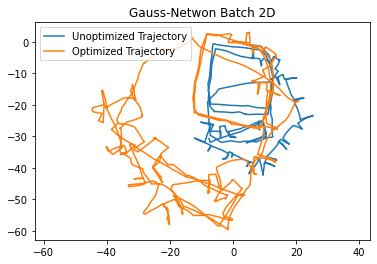

In [5]:
graph = gtsam.NonlinearFactorGraph()
init = gtsam.Values()

for pose in poses:
    init.insert(int(pose[0]),gtsam.Pose2(pose[1],pose[2],pose[3]))

prior_model = gtsam.noiseModel.Diagonal.Variances(np.array([0.3, 0.3, 0.1]))
graph.add(gtsam.PriorFactorPose2(0, init.atPose2(0), prior_model))

for edge in edges:
    model = gtsam.noiseModel.Gaussian.Covariance(edge[5])
    graph.add(gtsam.BetweenFactorPose2(edge[0],edge[1],gtsam.Pose2(edge[2],edge[3],edge[4]),model))

params = gtsam.GaussNewtonParams()
optimizer = gtsam.GaussNewtonOptimizer(graph, init, params)
result = optimizer.optimize()

opt_poses = gtsam.utilities.extractPose2(result)
    
plt.plot(poses[:,1],poses[:,2])
plt.plot(opt_poses[:,0],opt_poses[:,1])
plt.title('Gauss-Netwon Batch 2D')
plt.legend(['Unoptimized Trajectory', 'Optimized Trajectory'])
plt.axis('equal')
plt.show()


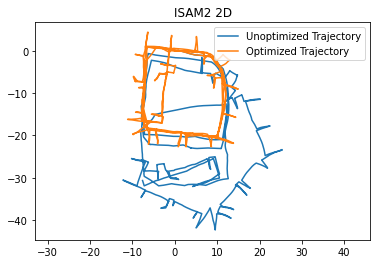

In [6]:
graph = gtsam.NonlinearFactorGraph()
init = gtsam.Values()

params = gtsam.ISAM2Params()
isam = gtsam.ISAM2(params)

for ii, pose in enumerate(poses):
    
    if(ii==0):
        init.insert(int(pose[0]),gtsam.Pose2(pose[1],pose[2],pose[3]))
        prior_model = gtsam.noiseModel.Diagonal.Variances(np.array([0.5, 0.5, 0.1]))
        graph.add(gtsam.PriorFactorPose2(0, init.atPose2(0), prior_model))
    else:
        init.insert(int(pose[0]),result.atPose2(ii-1))

    for edge in edges:
      if(edge[1]==ii):
        model = gtsam.noiseModel.Gaussian.Covariance(edge[5])
        graph.add(gtsam.BetweenFactorPose2(edge[0],edge[1],gtsam.Pose2(edge[2],edge[3],edge[4]),model))

    isam.update(graph,init)
    result = isam.calculateEstimate()
    graph.resize(0)
    init.clear()
    
opt_poses = gtsam.utilities.extractPose2(result)

plt.plot(poses[:,1],poses[:,2])
plt.plot(opt_poses[:,0],opt_poses[:,1])
plt.title('ISAM2 2D')
plt.legend(['Unoptimized Trajectory', 'Optimized Trajectory'])
plt.axis('equal')
plt.show()